# Third Harmonic Generation

In this example, we consider wave propagation through a simple 1d nonlinear medium with a non-zero Kerr susceptibility $\chi^{(3)}$. See also Materials and Units and Nonlinearity. We send in a narrow-band pulse at a frequency $\omega$, and because of the nonlinearity we also get a signal at a frequency $3\omega$.

Since this is a 1d calculation, we could implement it via a 2d cell of `Vector3(S,0,0)`, specifying periodic boundary conditions in the `y` direction. However, this is slightly inefficient since the `y` periodic boundaries are implemented internally via extra "ghost pixels" in the `y` direction. Instead, Meep has special support for 1d simulations in the `z` direction. To use this, we must explicitly set dimensions to 1, and in that case we can only use $E_x$ (and $D_x$) and $H_y$ field components. This involves no loss of generality because of the symmetry of the problem.

First, we'll load the necessary modules:

In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

Using MPI version 3.1, 1 processes


Next, we'll define some parameters of our simulation:

In [2]:
sz = 100              # size of cell in z direction
fcen = 1 / 3.0        # center frequency of source
df = fcen / 20.0      # frequency width of source
amp = 1               # amplitude of source
k = 10**-5            # Kerr susceptibility
dpml = 1.0            # PML thickness

Now, to define our cell, we'll do:

In [3]:
dimensions = 1
cell = mp.Vector3(0, 0, sz)
pml_layers = mp.PML(dpml)
resolution = 20

Note that this will only put PMLs at the $\pm z$ boundaries.

In this case, we're going to fill the entire computational cell with the nonlinear medium, so we don't need to use any objects. We can just use the special `default_material` which is ordinarily vacuum:

In [4]:
default_material = mp.Medium(index=1, chi3=k)

Now, our source will be a Gaussian pulse of $J_x$ just next to the $−z$ PML layer. Since this is a nonlinear calculation, we may want to play with the amplitude of the current/field, so we set the amplitude property explicitly to our parameter `amp`, above.

In [5]:
sources = mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Ex,
                    center=mp.Vector3(0, 0, -0.5*sz + dpml), amplitude=amp)

We'll want the frequency spectrum at the $+z$ end of the computational cell. In a linear problem, we normally look at the spectrum over the same frequency range as our source, because other frequencies are zero. In this case, however, we will look from `fcen/2` to `4*fcen`, to be sure that we can see the third-harmonic frequency.

In [6]:
nfreq = 400
fmin = fcen / 2.0
fmax = fcen * 4

sim = mp.Simulation(cell_size=cell,
                    geometry=[],
                    sources=[sources],
                    boundary_layers=[pml_layers],
                    default_material=default_material,
                    resolution=resolution,
                    dimensions=dimensions)

trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                     mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 0.5)))

Finally, we'll run the sources, plus additional time for the field to decay at the flux plane, and output the flux spectrum:

In [7]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ex, mp.Vector3(0, 0, 0.5*sz - dpml - 0.5), 1e-6))

-----------
Initializing structure...
field decay(t = 100.05000000000001): 4.1691008357827005e-12 / 4.1691008357827005e-12 = 1.0
field decay(t = 150.07500000000002): 1.0165420168812386e-08 / 1.0165420168812386e-08 = 1.0
field decay(t = 200.10000000000002): 4.650785262405232e-06 / 4.650785262405232e-06 = 1.0
field decay(t = 250.125): 0.0005454866366283557 / 0.0005454866366283557 = 1.0
field decay(t = 300.15000000000003): 0.017815669509667658 / 0.017815669509667658 = 1.0
field decay(t = 350.175): 0.13192124155368243 / 0.13192124155368243 = 1.0
field decay(t = 400.20000000000005): 0.2505510561658855 / 0.2505510561658855 = 1.0
field decay(t = 450.225): 0.2499503102652878 / 0.2505510561658855 = 0.9976023014638582
field decay(t = 500.25): 0.11167289094888443 / 0.2505510561658855 = 0.4457091207587955
field decay(t = 550.275): 0.012841517437730344 / 0.2505510561658855 = 0.05125309641172774
field decay(t = 600.3000000000001): 0.0003786349795018242 / 0.2505510561658855 = 0.0015112088741351644
fi

In a linear calculation, we normalize the transmission against some reference spectrum, but in this case there is no obvious normalization so we will just plot the raw data. To do so, we'll pull the frequency points using `get_flux_freqs()` and the corrensponding spectra using `get_flux_freqs()`.

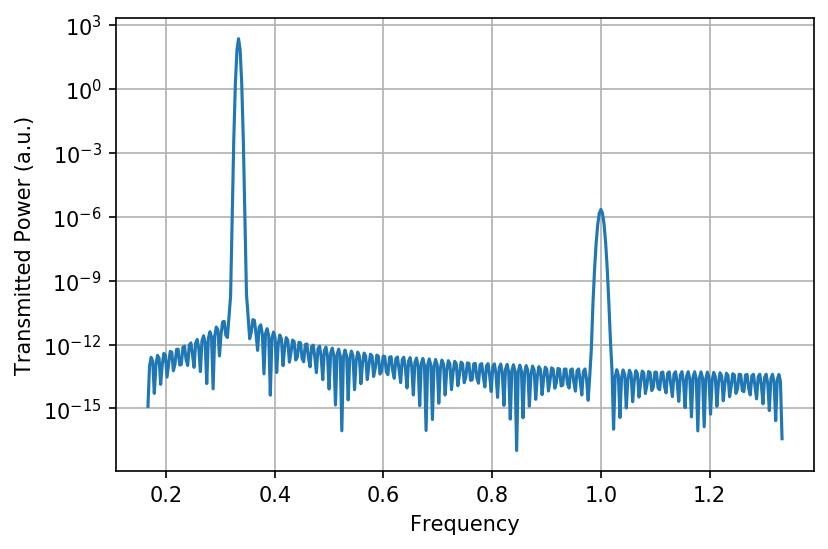

In [8]:
freqs = mp.get_flux_freqs(trans)
spectra = mp.get_fluxes(trans)

plt.figure(dpi=150)
plt.semilogy(freqs,spectra)
plt.grid(True)
plt.xlabel('Frequency')
plt.ylabel('Transmitted Power (a.u.)')
plt.show()

We next want to see what happens as we slowly increase our nonlinearity term ($\chi^{(3)}$). We'll wrap our routine in a function and parameterize it so that we can quickly loop over the various nonlinearities.

It is also interesting to have a more detailed look at the dependence of the power at $\omega$ and $3\omega$ as a function of $\chi^{(3)}$ and the current amplitude. We could, of course, interpolate the flux spectrum above to get the desired frequencies, but it is easier just to add two more flux regions to Meep and request exactly the desired frequency components. We'll add the additional fluxes to our function:

In [9]:
def run_chi3(k_pow,amp=1):
    k = 10**k_pow 
    default_material = mp.Medium(index=1, chi3=k)
    
    sources = mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Ex,
                    center=mp.Vector3(0, 0, -0.5*sz + dpml), amplitude=amp)
    
    sim = mp.Simulation(cell_size=cell,
                    geometry=[],
                    sources=[sources],
                    boundary_layers=[pml_layers],
                    default_material=default_material,
                    resolution=resolution,
                    dimensions=dimensions)

    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                     mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 0.5)))
    
    # Single frequency point at omega
    trans1 = sim.add_flux(fcen, 0, 1,
                      mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 0.5)))

    # Singel frequency point at 3omega
    trans3 = sim.add_flux(3 * fcen, 0, 1,
                      mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 0.5)))
    
    sim.run(until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ex, mp.Vector3(0, 0, 0.5*sz - dpml - 0.5), 1e-6))
    
    omega_flux = mp.get_fluxes(trans1)
    omega3_flux = mp.get_fluxes(trans3)
    freqs = mp.get_flux_freqs(trans)
    spectra = mp.get_fluxes(trans)
    
    return freqs, spectra, omega_flux, omega3_flux

We'll now loop over various nonlinearities to see what effect this has on our frequency response.

In [10]:
k_pow = [-3,-2,-1,0]
freqs = []
spectra = []
for k_iter in k_pow:
    freqs_iter, spectra_iter, omega_flux, omega3_flux = run_chi3(k_iter)
    spectra.append(spectra_iter)
    freqs = freqs_iter # Each iteration will simulate over the same frequencies, so just remember the last set.

-----------
Initializing structure...
field decay(t = 100.05000000000001): 4.1691008357817126e-12 / 4.1691008357817126e-12 = 1.0
field decay(t = 150.07500000000002): 1.0165420158581846e-08 / 1.0165420158581846e-08 = 1.0
field decay(t = 200.10000000000002): 4.650783221205379e-06 / 4.650783221205379e-06 = 1.0
field decay(t = 250.125): 0.0005454598673598967 / 0.0005454598673598967 = 1.0
field decay(t = 300.15000000000003): 0.017781404956060017 / 0.017781404956060017 = 1.0
field decay(t = 350.175): 0.13014055244440104 / 0.13014055244440104 = 1.0
field decay(t = 400.20000000000005): 0.2443206506136912 / 0.2443206506136912 = 1.0
field decay(t = 450.225): 0.2437445632391615 / 0.2443206506136912 = 0.9976420848050188
field decay(t = 500.25): 0.11044620451678894 / 0.2443206506136912 = 0.4520543156682302
field decay(t = 550.275): 0.012822890989720101 / 0.2443206506136912 = 0.05248386068681144
field decay(t = 600.3000000000001): 0.00037862010232358545 / 0.2443206506136912 = 0.0015496852246118257
f

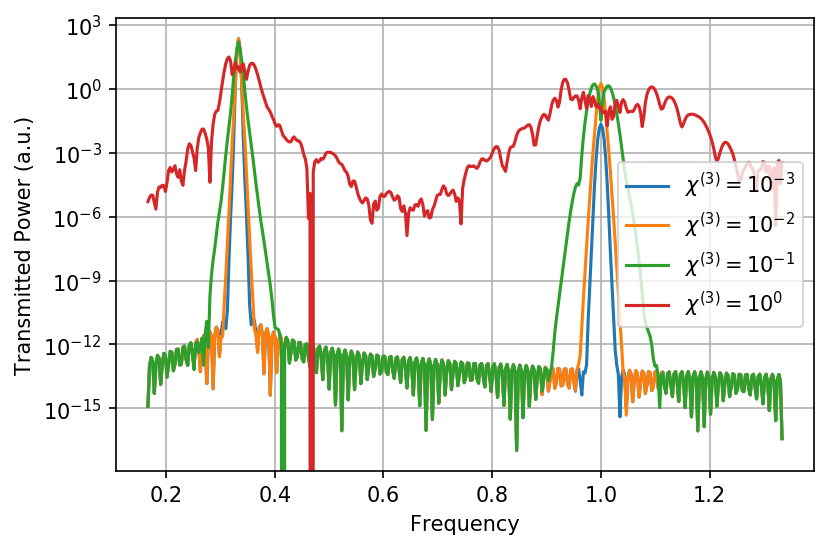

In [11]:
plt.figure(dpi=150)
plt.semilogy(freqs,np.array(spectra).T)
plt.grid(True)
plt.xlabel('Frequency')
plt.ylabel('Transmitted Power (a.u.)')
plt.legend(["$\chi^{{(3)}} = 10^{{{}}}$".format(i) for i in k_pow])
plt.show()

For small values of $\chi^{(3)}$, we see a peak from our source at $\omega=1/3$ and another peak precisely at the third-harmonic frequency $3\oemega=1$. As the $\chi^{(3)}$ gets larger, frequency-mixing within the peaks causes them to broaden, and finally for $\chi^{(3)}=1$ we start to see a noisy, broad-spectrum transmission due to the phenomenon of _modulation instability_. Notice also that at around $10^{−13}$ the data looks weird; this is probably due to our finite simulation time, imperfect absorbing boundaries, etcetera. We haven't attempted to analyze it in detail for this case.

Now, we can look specifically at our frequencies of interest. We'll run a quick simulation for a linear medium. We'll measure the PSD at $\omega$ and use this as a calibration factor for much larger nonlinearities.

In [12]:
_, _, omega_flux_cal, omega3_flux_cal = run_chi3(-16)
print("Omega: {}, 3Omega: {}".format(omega_flux_cal[0],omega3_flux_cal[0]))

-----------
Initializing structure...
field decay(t = 100.05000000000001): 4.1691008357827595e-12 / 4.1691008357827595e-12 = 1.0
field decay(t = 150.07500000000002): 1.016542016891584e-08 / 1.016542016891584e-08 = 1.0
field decay(t = 200.10000000000002): 4.650785283023354e-06 / 4.650785283023354e-06 = 1.0
field decay(t = 250.125): 0.0005454869069704206 / 0.0005454869069704206 = 1.0
field decay(t = 300.15000000000003): 0.017816014066636514 / 0.017816014066636514 = 1.0
field decay(t = 350.175): 0.13193941695549694 / 0.13193941695549694 = 1.0
field decay(t = 400.20000000000005): 0.2506140638300714 / 0.2506140638300714 = 1.0
field decay(t = 450.225): 0.2500128531691806 / 0.2506140638300714 = 0.9976010497906516
field decay(t = 500.25): 0.11168480654371428 / 0.2506140638300714 = 0.4456446092324733
field decay(t = 550.275): 0.012841704978003306 / 0.2506140638300714 = 0.05124095903376999
field decay(t = 600.3000000000001): 0.0003786351315011641 / 0.2506140638300714 = 0.001510829542901859
field

That is, the linear transmission is 225.25726603587026 at $\omega$, so we'll loop through several nonlinearities, divide by this value, and plot the fractional transmission at $\omega$ and $3\omega$ as a function of $\chi1^{(3)}$ on a log-log scale.

In [13]:
pts = np.linspace(-6,0,20)
_, _, omega_psd, omega3_psd = zip(*[run_chi3(k_iter) for k_iter in pts])

-----------
Initializing structure...
field decay(t = 100.05000000000001): 4.1691008357827595e-12 / 4.1691008357827595e-12 = 1.0
field decay(t = 150.07500000000002): 1.0165420168905492e-08 / 1.0165420168905492e-08 = 1.0
field decay(t = 200.10000000000002): 4.650785280961551e-06 / 4.650785280961551e-06 = 1.0
field decay(t = 250.125): 0.0005454868799362667 / 0.0005454868799362667 = 1.0
field decay(t = 300.15000000000003): 0.017815979612345514 / 0.017815979612345514 = 1.0
field decay(t = 350.175): 0.13193760003745314 / 0.13193760003745314 = 1.0
field decay(t = 400.20000000000005): 0.2506077676780644 / 0.2506077676780644 = 1.0
field decay(t = 450.225): 0.250006603482365 / 0.2506077676780644 = 0.9976011749305723
field decay(t = 500.25): 0.1116836154292776 / 0.2506077676780644 = 0.4456510524955018
field decay(t = 550.275): 0.012841686224530456 / 0.2506077676780644 = 0.051242171555620476
field decay(t = 600.3000000000001): 0.00037863511629851986 / 0.2506077676780644 = 0.0015108674396115361
fi

field decay(t = 600.3000000000001): 0.0003786339402465762 / 0.25011687030360397 = 0.0015138280747994807
field decay(t = 650.325): 2.416110058754147e-06 / 0.25011687030360397 = 9.659924401826058e-06
field decay(t = 700.35): 4.491037714235971e-09 / 0.25011687030360397 = 1.795575687791284e-08
run 0 finished at t = 700.35 (28014 timesteps)
-----------
Initializing structure...
field decay(t = 100.05000000000001): 4.169100835782566e-12 / 4.169100835782566e-12 = 1.0
field decay(t = 150.07500000000002): 1.016542016723775e-08 / 1.016542016723775e-08 = 1.0
field decay(t = 200.10000000000002): 4.650784948230582e-06 / 4.650784948230582e-06 = 1.0
field decay(t = 250.125): 0.0005454825170836912 / 0.0005454825170836912 = 1.0
field decay(t = 300.15000000000003): 0.01781041537070784 / 0.01781041537070784 = 1.0
field decay(t = 350.175): 0.1316425937154995 / 0.1316425937154995 = 1.0
field decay(t = 400.20000000000005): 0.24957847104378408 / 0.24957847104378408 = 1.0
field decay(t = 450.225): 0.248984835

field decay(t = 400.20000000000005): 0.20163815113463796 / 0.20163815113463796 = 1.0
field decay(t = 450.225): 0.20120253259282825 / 0.20163815113463796 = 0.9978396025783889
field decay(t = 500.25): 0.10109030457587416 / 0.20163815113463796 = 0.5013451274326259
field decay(t = 550.275): 0.01262521101057978 / 0.20163815113463796 = 0.06261320558404479
field decay(t = 600.3000000000001): 0.0003784354270167391 / 0.20163815113463796 = 0.0018768046864506805
field decay(t = 650.325): 2.4161436765026146e-06 / 0.20163815113463796 = 1.1982572062413455e-05
field decay(t = 700.35): 4.492170330890932e-09 / 0.20163815113463796 = 2.2278374928618628e-08
run 0 finished at t = 700.35 (28014 timesteps)
-----------
Initializing structure...
field decay(t = 100.05000000000001): 4.169100835754938e-12 / 4.169100835754938e-12 = 1.0
field decay(t = 150.07500000000002): 1.01654198964457e-08 / 1.01654198964457e-08 = 1.0
field decay(t = 200.10000000000002): 4.650730917976917e-06 / 4.650730917976917e-06 = 1.0
fiel

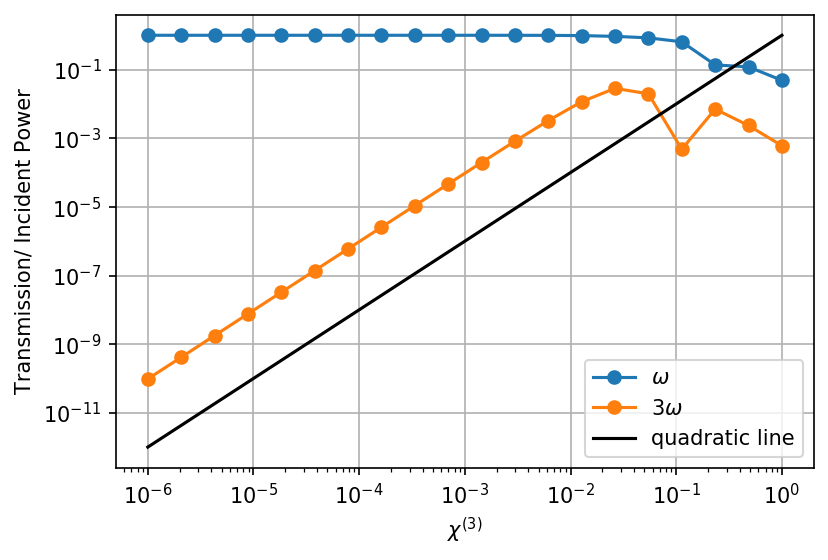

In [14]:
quad = (10 ** pts) ** 2

plt.figure(dpi=150)
plt.loglog(10 ** pts,np.array(omega_psd)/omega_flux_cal[0],'o-',label='$\omega$')
plt.loglog(10 ** pts,np.array(omega3_psd)/omega_flux_cal[0],'o-',label='$3\omega$')
plt.loglog(10**pts,quad,'k',label='quadratic line')
plt.grid(True)
plt.xlabel('$\chi^{(3)}$')
plt.ylabel('Transmission/ Incident Power')
plt.legend()
plt.show()

As can be shown from coupled-mode theory or, equivalently, follows from Fermi's golden rule, the third-harmonic power must go as the square of $\chi^{(3)}$ as long as the nonlinearity is weak (i.e. in the first Born approximation limit, where the $\omega$ source is not depleted significantly). This is precisely what we see on the above graph, where the slope of the black line indicates an exact quadratic dependence, for comparison. Once the nonlinearity gets strong enough, however, this approximation is no longer valid and the dependence is complicated.

Finally, we note that increasing the current amplitude by a factor of $F$ or the Kerr susceptibility $\chi^{(3)}$ by a factor $F^3$ should generate the same third-harmonic power in the weak nonlinearity approximation. And indeed, we see:

In [15]:
_, _, omega_flux_1, omega3_flux_1 = run_chi3(-3,1)
_, _, omega_flux_2, omega3_flux_2 = run_chi3(-6,10)

print('-------------------------------')
print("Difference between powers: {}%".format(abs(omega3_flux_1[0]-omega3_flux_2[0])/omega3_flux_1[0] * 100))

-----------
Initializing structure...
field decay(t = 100.05000000000001): 4.1691008357817126e-12 / 4.1691008357817126e-12 = 1.0
field decay(t = 150.07500000000002): 1.0165420158581846e-08 / 1.0165420158581846e-08 = 1.0
field decay(t = 200.10000000000002): 4.650783221205379e-06 / 4.650783221205379e-06 = 1.0
field decay(t = 250.125): 0.0005454598673598967 / 0.0005454598673598967 = 1.0
field decay(t = 300.15000000000003): 0.017781404956060017 / 0.017781404956060017 = 1.0
field decay(t = 350.175): 0.13014055244440104 / 0.13014055244440104 = 1.0
field decay(t = 400.20000000000005): 0.2443206506136912 / 0.2443206506136912 = 1.0
field decay(t = 450.225): 0.2437445632391615 / 0.2443206506136912 = 0.9976420848050188
field decay(t = 500.25): 0.11044620451678894 / 0.2443206506136912 = 0.4520543156682302
field decay(t = 550.275): 0.012822890989720101 / 0.2443206506136912 = 0.05248386068681144
field decay(t = 600.3000000000001): 0.00037862010232358545 / 0.2443206506136912 = 0.0015496852246118257
f

which have third-harmonic powers differing by about 1%.